## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

/Users/akovel/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре. 

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [2]:
df = pd.read_csv('data/interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [3]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
2736703,388382,16166,149,11813,100.0
4249315,1018589,3363,104,13715,100.0
1504534,756208,7731,54,5517,90.0
3063271,750922,11312,12,873,13.0
2636200,45400,4151,128,1586,13.0


Сделаем разбиение по времени

<Axes: >

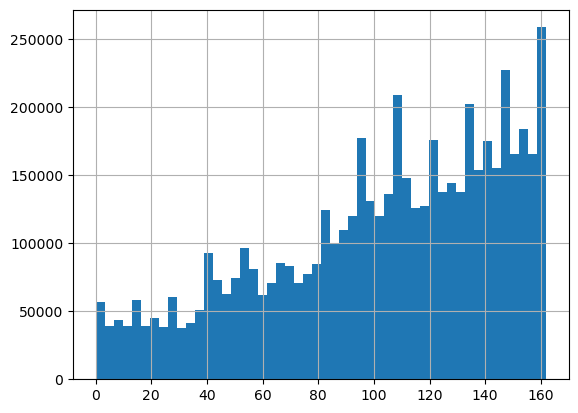

In [4]:
df.last_watch_dt.hist(bins=50)

In [5]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [6]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [7]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [8]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
28,81786,2616,133,41422,90.0
119,10543,821,64,112,0.0
278,963902,9996,82,3268,10.0
338,1023844,14359,105,6652,100.0
481,1023516,9585,149,14,0.0


In [9]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

/var/folders/zz/gp2ff22x0kd0hxvd61_3_hc00000gn/T/ipykernel_77779/1105526701.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
/var/folders/zz/gp2ff22x0kd0hxvd61_3_hc00000gn/T/ipykernel_77779/1105526701.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


,user_id,train_interactions
0,47,"[(13361, 138), (13865, 138), (7401, 142), (129..."
1,272,"[(12869, 40), (11310, 112)]"
2,513,"[(12173, 31), (3940, 35), (8980, 42), (5847, 4..."
3,681,"[(9728, 112), (4533, 116), (13789, 116), (1470..."
4,764,"[(11115, 49), (15404, 49), (16361, 49), (12770..."


In [10]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,47,"[(13361, 138), (13865, 138), (7401, 142), (129...","[(14488, 160)]"
1,272,"[(12869, 40), (11310, 112)]","[(5398, 156), (9728, 156), (6561, 156), (15214..."
2,513,"[(12173, 31), (3940, 35), (8980, 42), (5847, 4...","[(1916, 159)]"
3,681,"[(9728, 112), (4533, 116), (13789, 116), (1470...","[(7389, 154), (8617, 154)]"
4,764,"[(11115, 49), (15404, 49), (16361, 49), (12770...","[(4000, 159)]"


In [11]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,47,"[(13361, 138), (13865, 138), (7401, 142), (129...","[(14488, 160)]","[15744, 922, 12119]"
1,272,"[(12869, 40), (11310, 112)]","[(5398, 156), (9728, 156), (6561, 156), (15214...","[15744, 922, 12119]"
2,513,"[(12173, 31), (3940, 35), (8980, 42), (5847, 4...","[(1916, 159)]","[15744, 922, 12119]"
3,681,"[(9728, 112), (4533, 116), (13789, 116), (1470...","[(7389, 154), (8617, 154)]","[15744, 922, 12119]"
4,764,"[(11115, 49), (15404, 49), (16361, 49), (12770...","[(4000, 159)]","[15744, 922, 12119]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$. 

In [42]:
def ap_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is not None:
        predictions = predictions[:topn]    
    n_u = len(gt_items)
    if n_u == 0:
        return 0.0

    relevant = np.isin(predictions, gt_items)
    cumulative_relevant = np.cumsum(relevant)
    p_u = cumulative_relevant / np.arange(1, len(predictions) + 1)
    ap = (1 / min(len(predictions), n_u)) * np.sum(relevant[:len(predictions)] * p_u)

    return ap

def rr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    predictions = np.array(predictions)

    if topn is not None:
        predictions = predictions[:topn]    
    relevant_mask = np.isin(predictions, gt_items)    
    first_relevant_index = np.where(relevant_mask)[0]
    if first_relevant_index.size == 0:
        return 0.0
    
    rank = first_relevant_index[0] + 1
    return 1.0 / rank

def hr_metric(
    gt_items: List[int],
    predictions: List[int],
    topn: Optional[int]=None
):
    if topn is not None:
        predictions = predictions[:topn]
    hit = np.any(np.isin(predictions, gt_items))
    return 1.0 if hit else 0.0


Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит. 

In [43]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать. 

In [44]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [45]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.0, 'mrr': 0.0, 'hr': 0.0}

In [46]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,47,"[(13361, 138), (13865, 138), (7401, 142), (129...","[(14488, 160)]","[15744, 922, 12119]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
1,272,"[(12869, 40), (11310, 112)]","[(5398, 156), (9728, 156), (6561, 156), (15214...","[15744, 922, 12119]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
2,513,"[(12173, 31), (3940, 35), (8980, 42), (5847, 4...","[(1916, 159)]","[15744, 922, 12119]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
3,681,"[(9728, 112), (4533, 116), (13789, 116), (1470...","[(7389, 154), (8617, 154)]","[15744, 922, 12119]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
4,764,"[(11115, 49), (15404, 49), (16361, 49), (12770...","[(4000, 159)]","[15744, 922, 12119]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [47]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.06666990641534391, 'mrr': 0.11944630952380954, 'hr': 0.2691}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [72]:
from collections import defaultdict

class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window
        self.trained = False
        self.recommenations = []
        self.item_weights = defaultdict(int)


    def fit(self, df, col='train_interactions'):
        interaction_counts = df[col].apply(lambda x: len(x))
        filtered_interactions = interaction_counts[interaction_counts >= self.min_window]
        for _, row in df.iterrows():
            items = row[col]  
            weight = len(items) 
            for item, _ in items:
                if item in filtered_interactions.index:
                    self.item_weights[item] += weight 
        self.item_weights = dict(self.item_weights)
        self.recommenations = sorted(self.item_weights.items(), key=lambda x: x[1], reverse=True)
        self.trained = True

    def predict(self, df, top_n=10):
        assert self.trained
        return [[item for item, weight in  self.recommenations[:top_n]]]*len(df)
    
toppopweighted = TopPopularWeighted()
toppopweighted.fit(joined)

joined['toppopularweighted_recs'] = toppopweighted.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppopularweighted_recs
0,47,"[(13361, 138), (13865, 138), (7401, 142), (129...","[(14488, 160)]","[15744, 922, 12119]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 4151, 4880, 2657, 142, 7571, 9996, 7102..."
1,272,"[(12869, 40), (11310, 112)]","[(5398, 156), (9728, 156), (6561, 156), (15214...","[15744, 922, 12119]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 4151, 4880, 2657, 142, 7571, 9996, 7102..."
2,513,"[(12173, 31), (3940, 35), (8980, 42), (5847, 4...","[(1916, 159)]","[15744, 922, 12119]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 4151, 4880, 2657, 142, 7571, 9996, 7102..."
3,681,"[(9728, 112), (4533, 116), (13789, 116), (1470...","[(7389, 154), (8617, 154)]","[15744, 922, 12119]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 4151, 4880, 2657, 142, 7571, 9996, 7102..."
4,764,"[(11115, 49), (15404, 49), (16361, 49), (12770...","[(4000, 159)]","[15744, 922, 12119]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 4151, 4880, 2657, 142, 7571, 9996, 7102..."


Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна. 

In [73]:
evaluate_recommender(joined, model_preds='toppopularweighted_recs')

{'map': 0.044243040028974556, 'mrr': 0.09051365079365079, 'hr': 0.1639}

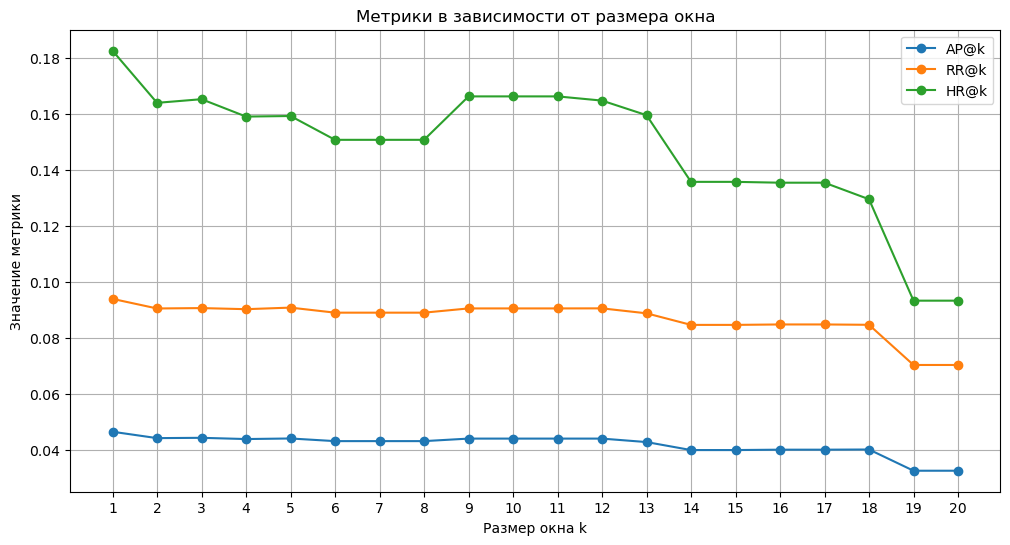

In [74]:
window_sizes = range(1, 21)
ap_scores = []
rr_scores = []
hr_scores = []


for window_size in window_sizes:    
    toppopweighted = TopPopularWeighted(min_window=window_size)
    toppopweighted.fit(joined)

    joined['toppopularweighted_recs'] = toppopweighted.predict(joined)
    
    metrics = evaluate_recommender(joined, model_preds='toppopularweighted_recs')
    
    ap_scores.append(metrics['map'])
    rr_scores.append(metrics['mrr'])
    hr_scores.append(metrics['hr'])

plt.figure(figsize=(12, 6))
plt.plot(window_sizes, ap_scores, label='AP@k', marker='o')
plt.plot(window_sizes, rr_scores, label='RR@k', marker='o')
plt.plot(window_sizes, hr_scores, label='HR@k', marker='o')

plt.title('Метрики в зависимости от размера окна')
plt.xlabel('Размер окна k')
plt.ylabel('Значение метрики')
plt.xticks(window_sizes)
plt.grid()
plt.legend()
plt.show()

Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:** Окно должно работать с актуалоьностью пользовательского настроения. Если взять очень большое окно, то уже в модель могут попасть не актуальные данные. То есть надо брать разумно небольшое окно. На данном графике это 10

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике. 

In [75]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

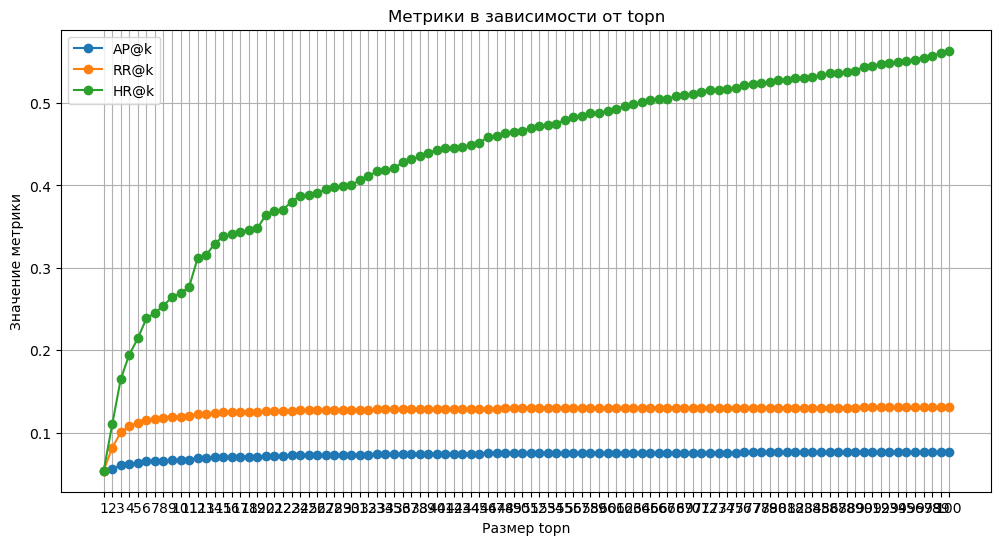

In [79]:
ap_scores = []
rr_scores = []
hr_scores = []

topns = range(1, 101)

for top_n in topns:    

    joined['toppopular_recs'] = toppop.predict(joined, topn=top_n)
    
    metrics = evaluate_recommender(joined, model_preds='toppopular_recs')
    
    ap_scores.append(metrics['map'])
    rr_scores.append(metrics['mrr'])
    hr_scores.append(metrics['hr'])

plt.figure(figsize=(12, 6))
plt.plot(topns, ap_scores, label='AP@k', marker='o')
plt.plot(topns, rr_scores, label='RR@k', marker='o')
plt.plot(topns, hr_scores, label='HR@k', marker='o')

plt.title('Метрики в зависимости от topn')
plt.xlabel('Размер topn')
plt.ylabel('Значение метрики')
plt.xticks(topns)
plt.grid()
plt.legend()
plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:** RR, AP. MAP - занижается при увелечении top-K, в какой-то момент просто не может расти. RR - ожидает первый реливантый, логично, что при росте top-K не будет расти

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \
**Ответ:** Хитрейт показывает, что чем дольше будет пользователь крутить, тем больше вероятнсоть, что ему понравится. AP - показывает интерес пользователя, что в какой-то момент из-за смешенности рекомендаций, не получится идеально долго попадать в интересы. Hitrate - просто показывает, когда попалась качественная рекомендация, с каой скоростью.

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ:** Так, как мы подбираем самые популярные (которые нравятся большинству), то графики вполне логичны. Какое-то время будут интересные рекомендации в топе, потом может отличатся сильно от вкусов пользователя.

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей. 

In [83]:
items = pd.read_csv('data/items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

1917


<Axes: >

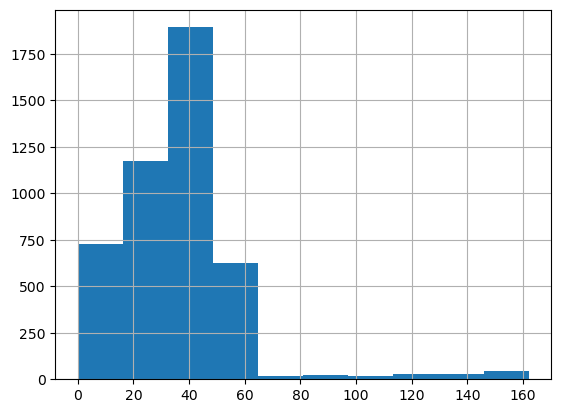

In [84]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной. 

Добавьте 5 своих примеров ниже. Опишите, как вы их искали. 

In [90]:
joined['toppopularweighted_recs'][0][:-5]

[9728, 4495, 3784, 7582, 7310]

Гнев человеческий


<Axes: >

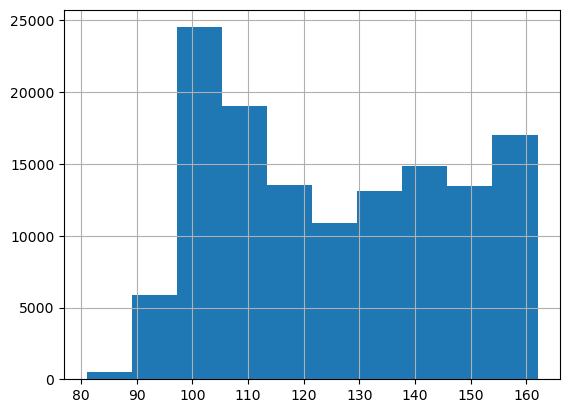

In [93]:
sampled_id = 9728

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Пальмира


<Axes: >

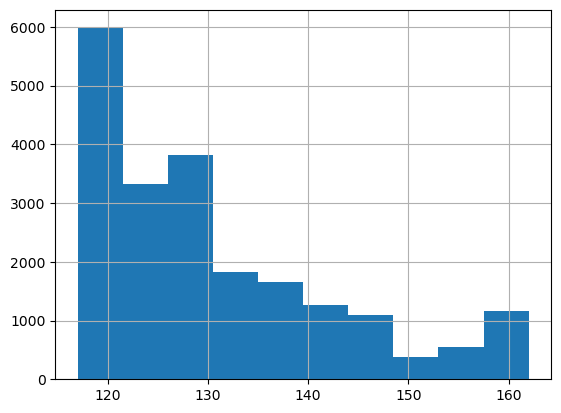

In [94]:
sampled_id = 4495

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Маленький воин


<Axes: >

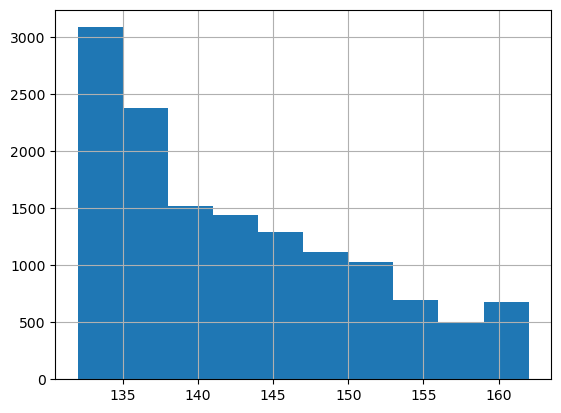

In [95]:
sampled_id = 3784

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Холодное сердце II


<Axes: >

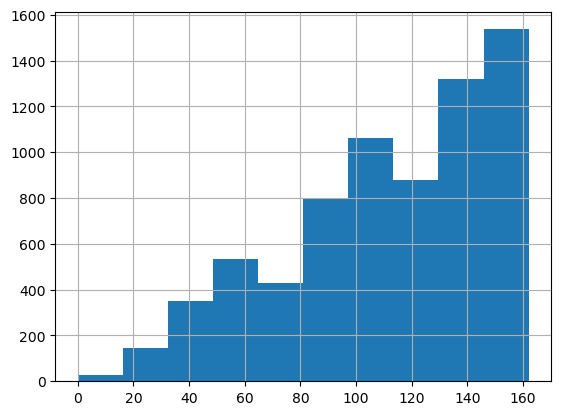

In [96]:
sampled_id = 7582

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Гадкий я 2


<Axes: >

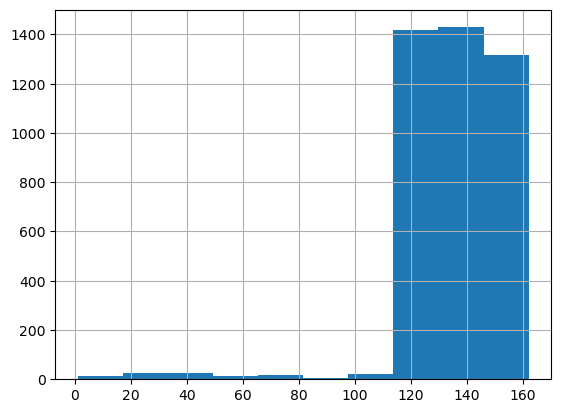

In [97]:
sampled_id = 7310

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Привел 5 графиков, которые просто взял из популярных. И кстати, почти из них все отражают разный интерес публики.

1. Гнев человеческий --- обладал очень сильной рекламой, и просто висел долго в топе на площадках. При этом виден постепенный рост популярности, так как фильм не супер-пупер блокбастер, и не сразу имел большой интерес у публики
2. Пальмира --- видно из абсолютных чисел, что не совсем популярный фильм. Видимо просто посмотрели на выходе и забыли
3. Маленький воин --- аналогично с Пальмирой
4. Холодное сердце II --- премьера не была внутри сервиса. И просто набирал популярность, как мультик убивалка времени
5. Гадкия я 2 --- также премьера была не на сервисе. И просто видимо показали пользователям, что он есть на сервисе. И все сразу стали включать детям.

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках. 

In [104]:
def filter_column(df, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items.
    """
    user_counts = df['user_id'].value_counts()
    item_counts = df['item_id'].value_counts()
    
    active_users = user_counts[user_counts > min_freq].index
    popular_items = item_counts[item_counts > min_freq].index
    
    filtered_df = df[(df['user_id'].isin(active_users)) & (df['item_id'].isin(popular_items))]
    
    return filtered_df

def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe.
    """
    filtered_df = df.copy()
    
    while True:
        new_filtered_df = filter_column(filtered_df, min_freq)
        
        if new_filtered_df.shape[0] == filtered_df.shape[0]:
            break
        
        filtered_df = new_filtered_df
    
    return filtered_df


In [168]:
filtered_train = filter_dataframe(df, ['user_id', 'item_id'], min_freq=4)

In [169]:
def df_encode(df):
    item2id = {k:v for v, k in enumerate(df.item_id.unique())}
    user2id = {k:v for v, k in enumerate(df.user_id.unique())}

    id2item = {k:v for v, k in item2id.items()}
    id2user = {k:v for v, k in user2id.items()}

    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])
    return df

filtered_train = df_encode(filtered_train)
filtered_train.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
1274769,70603,1707,133,8,0.0
2081884,98118,88,111,5909,96.0
5195711,11026,1995,158,2910,45.0
3812345,204516,76,162,882,15.0
988033,48265,1019,87,444,8.0


In [170]:
item2id = {k:v for v, k in enumerate(filtered_train.item_id.unique())}
user2id = {k:v for v, k in enumerate(filtered_train.user_id.unique())}

In [171]:
train_df_f = filtered_train

In [172]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(train_df_f.shape[0]), (train_df_f['user_id'], train_df_f['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<302205x10031 sparse matrix of type '<class 'numpy.float64'>'
	with 4278492 stored elements in COOrdinate format>

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра. 

In [129]:
min_freq_values = range(1, 10)
user_counts = []
item_counts = []

for i in range(1, 10):
    filtered_train = filter_dataframe(df, ['user_id', 'item_id'], min_freq=i)
    unique_users = filtered_train['user_id'].nunique()
    unique_items = filtered_train['item_id'].nunique()    
    user_counts.append(unique_users)
    item_counts.append(unique_items)

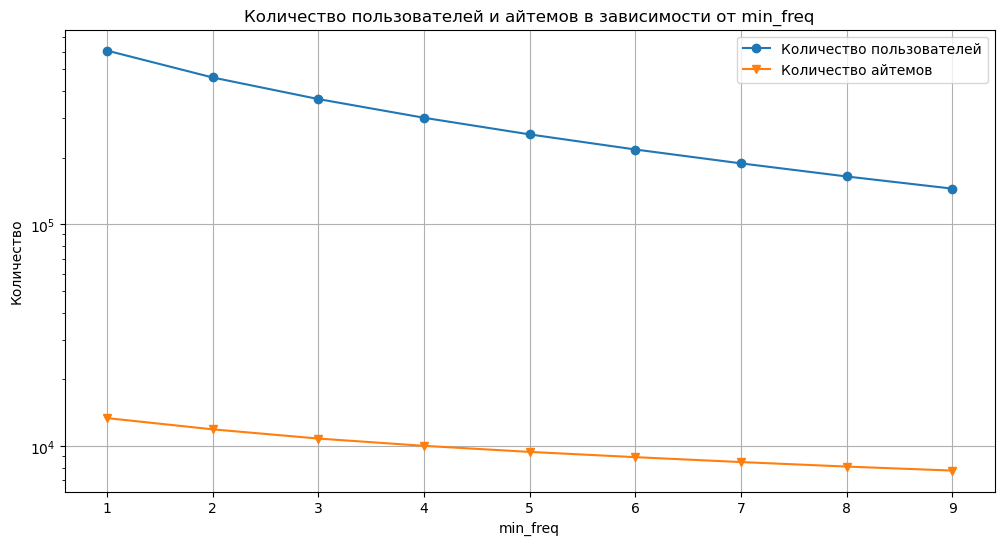

In [132]:
plt.figure(figsize=(12, 6))
plt.plot(min_freq_values, user_counts, marker='o', label='Количество пользователей')
plt.plot(min_freq_values, item_counts, marker='v', label='Количество айтемов')

plt.title('Количество пользователей и айтемов в зависимости от min_freq')
plt.xlabel('min_freq')
plt.ylabel('Количество')
plt.xticks(min_freq_values)
plt.legend()
plt.grid()
plt.yscale('log')
plt.show()

**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k. 

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [173]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole
#
def fit_ease(X, reg_weight=100):
    
 # gram matrix
    G = X.T @ X

    # add reg to diagonal
    G += reg_weight * sps.identity(G.shape[0])

    # convert to dense because inverse will be dense
    G = G.todense()

    # invert. this takes most of the time
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    # zero out diag
    np.fill_diagonal(B, 0.)
    
    return B

w = fit_ease(matrix)

CPU times: user 1min 23s, sys: 3.23 s, total: 1min 26s
Wall time: 14.6 s


Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [195]:
def get_preds(x, item2id, id2item, ease_matrix, topk=100):

    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]

    # Составляем вектор интеракций человека
    vector = np.zeros(len(item2id))
    vector[encoded] = 1

    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(ease_matrix))[0]#.toarray()
    preds[encoded==1] = -np.inf

    ranks = np.argsort(-preds)
    decoded = [id2item[t] for t in ranks][:topk]
    
    return decoded

joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, w))
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppopularweighted_recs,ease_preds
0,47,"[(13361, 138), (13865, 138), (7401, 142), (129...","[(14488, 160)]","[15744, 922, 12119]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 4495, 3784, 7582, 7310, 8447, 676, 734,...","[3400, 6642, 32, 952, 45, 146, 6089, 1415, 114..."
1,272,"[(12869, 40), (11310, 112)]","[(5398, 156), (9728, 156), (6561, 156), (15214...","[15744, 922, 12119]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 4495, 3784, 7582, 7310, 8447, 676, 734,...","[0, 6683, 6684, 6685, 6686, 6687, 6688, 6689, ..."
2,513,"[(12173, 31), (3940, 35), (8980, 42), (5847, 4...","[(1916, 159)]","[15744, 922, 12119]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 4495, 3784, 7582, 7310, 8447, 676, 734,...","[1133, 3896, 700, 4226, 519, 147, 212, 12, 171..."
3,681,"[(9728, 112), (4533, 116), (13789, 116), (1470...","[(7389, 154), (8617, 154)]","[15744, 922, 12119]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 4495, 3784, 7582, 7310, 8447, 676, 734,...","[214, 868, 394, 790, 146, 26, 7, 518, 1588, 39..."
4,764,"[(11115, 49), (15404, 49), (16361, 49), (12770...","[(4000, 159)]","[15744, 922, 12119]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ...","[9728, 4495, 3784, 7582, 7310, 8447, 676, 734,...","[1143, 2867, 5780, 132, 1352, 209, 293, 474, 9..."


In [199]:
evaluate_recommender(joined, model_preds='ease_preds')

{'map': 0.00023040660447042258, 'mrr': 0.0007199000667789074, 'hr': 0.0143}

Сделайте выводы — какой алгоритм работает лучше?

**Ответ:** Почему-то лучше отработал алгоритм TopPopular. По всем метрикам лучше выступил(

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации. 

In [197]:
reg_weights = np.logspace(1, 10, num=20, base=2)

ap_scores = []
rr_scores = []
hr_scores = []

for reg in reg_weights:
    B = fit_ease(matrix, reg_weight=reg)
    joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, B))

    metrics = evaluate_recommender(joined, model_preds='ease_preds')
    
    ap_scores.append(metrics['map'])
    rr_scores.append(metrics['mrr'])
    hr_scores.append(metrics['hr'])

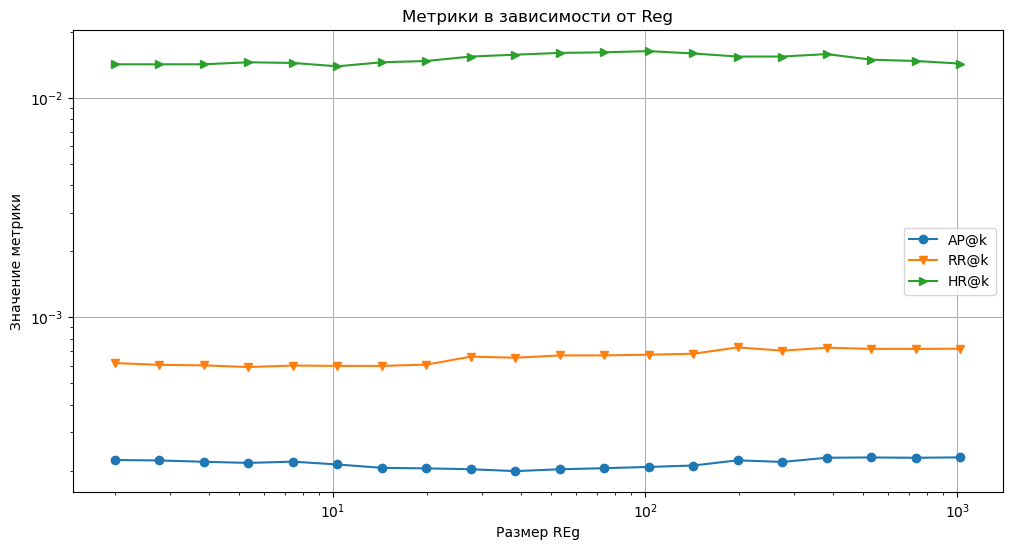

In [198]:
plt.figure(figsize=(12, 6))
plt.plot(reg_weights, ap_scores, label='AP@k', marker='o')
plt.plot(reg_weights, rr_scores, label='RR@k', marker='v')
plt.plot(reg_weights, hr_scores, label='HR@k', marker='>')

plt.title('Метрики в зависимости от Reg')
plt.xlabel('Размер REg')
plt.ylabel('Значение метрики')
plt.xticks(reg_weights)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим? 


**Ответ:** 1000

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:** В какой-то момент метрики все становились лучше, но в определенный порог могли не просто перестать расти, но начать падать

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

In [190]:
top_k_values = range(1, 101, 5)  
ap_scores = []
rr_scores = []
hr_scores = []
for top_k in top_k_values:
    B = fit_ease(matrix, reg_weight=100)  

    joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item, B, top_k))
    metrics = evaluate_recommender(joined, model_preds='ease_preds')
    
    ap_scores.append(metrics['map'])
    rr_scores.append(metrics['mrr'])
    hr_scores.append(metrics['hr'])

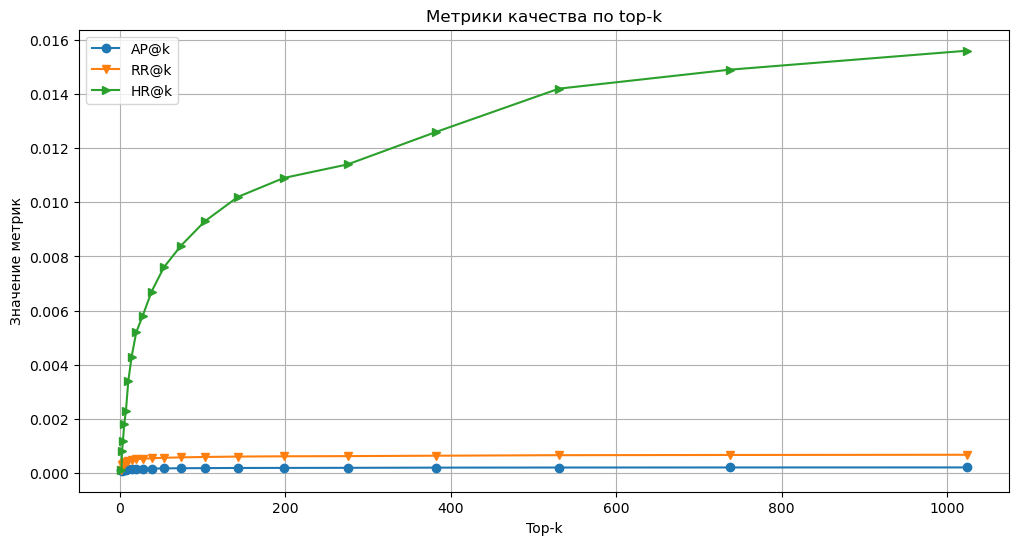

In [191]:
plt.figure(figsize=(12, 6))
plt.plot(reg_weights, ap_scores, label='AP@k', marker='o')
plt.plot(reg_weights, rr_scores, label='RR@k', marker='v')
plt.plot(reg_weights, hr_scores, label='HR@k', marker='>')

plt.title('Метрики качества по top-k')
plt.xlabel('Top-k')
plt.ylabel('Значение метрик')
plt.legend()
plt.grid()
plt.show()

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы. 

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:** Да, в целом, как и в прошлом задании с аналогичным изменениями

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций. 

In [239]:
joined['toppopular_recs'][0][-10:]

[12537, 12356, 12841, 2237, 5803, 6006, 14, 12623, 1399, 9070]

In [240]:
top_pop = [[i] for i in joined['toppopular_recs'][0][-10:]]

In [242]:
example_recommendations = get_preds(top_pop, item2id, id2item, w, topk=5)


example_recommendations

[140, 246, 202, 22, 4340]

In [241]:
items.loc[(items.item_id.isin(joined['toppopular_recs'][0][-10:]))]

,item_id,title
1722,9070,Рассказы
2492,14,Жестокий Стамбул
2803,12841,Стражи Галактики
2836,6006,Кости
4123,12356,13 грехов
5781,12623,Пираты карибского моря: Проклятие чёрной жемчу...
8621,1399,Молодость
12398,5803,Джой
13674,12537,Поли
15922,2237,Код 8


In [243]:
items.loc[(items.item_id.isin(example_recommendations))]

,item_id,title
1513,246,Обезьянки
5609,22,Андалузский пес
8402,202,Корпоратив
12061,4340,Интриганки
15294,140,Пришельцы в доме


Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:** получились рекомендаци: да. Почему: они есть, значит получились. Хороший пример: Обезьянки (хороший мультик), но в качестве рекомендации страно. Я бы сказал все плохие